# How to perform PRF photometry on Extra-Galactic Objects


In this tutorial, we will demonstrate a set of new tools introduced in `lightkurve` to perform PRF photometry on extra-galactic objects such as AGN. 
 

### Common difficulties : 
 - Crowded fields
 - Manual entry of priors

## Using `.get_priors()`

The function `.get_priors` is an automated way to generate a list of priors of all sources present in a given tpf. The prior returns 2 positional vectors (column, row) alongside with a flux and associated id number for each source. What's unique about `.get_priors()` is that it will also generate a prior for sources that have their PSF wings extend on the TPF. This altogetger will begin eliminating methods of contamination

In [14]:
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive(10645722, quarter=16, quality_bitmask='hardest') # okay 



In [15]:
prior = tpf.get_prior()

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
Only once source has been identified. Priors will be generated by the TPF


In [16]:
# Import stuff we need
import matplotlib.pyplot as plt
%matplotlib inline
from lightkurve import prf_photometry as prf_phot
from oktopus import GaussianPrior, UniformPrior
from lightkurve import prf as PRF
import numpy as np

In [17]:
bgflux = np.nanpercentile(tpf.flux[0], 10)

Star_trial = prf_phot.StarPrior(col=GaussianPrior(mean=prior[0], var=2**2),
                                              row=GaussianPrior(mean=prior[1], var=2**2),
                                              flux=UniformPrior(lb=0, ub=prior[2]),
                                              targetid=prior[3])

model_2 = prf_phot.SceneModel(star_priors=[Star_trial],
                   background_prior=prf_phot.BackgroundPrior(),
                    focus_prior=prf_phot.FocusPrior(scale_col=GaussianPrior(mean=1, var=0.0001),
                                           scale_row=GaussianPrior(mean=1, var=0.0001),
                                           rotation_angle=UniformPrior(lb=-3.1415, ub=3.1415)),
                   motion_prior=prf_phot.MotionPrior(shift_col=GaussianPrior(mean=0., var=0.01),
                                            shift_row=GaussianPrior(mean=0., var=0.01)),
                   prfmodel=prf_phot.KeplerPRF(tpf.channel, tpf.flux.shape[1:], tpf.column, tpf.row),
                   fit_background=True,
                   fit_focus=False,
                   fit_motion=False)

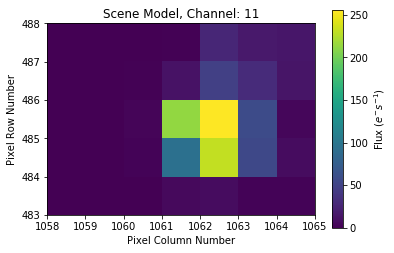

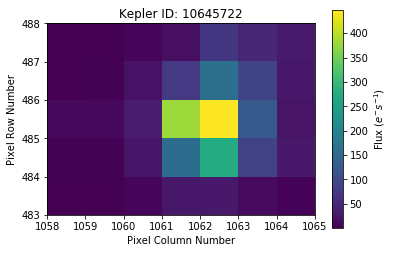

In [18]:
model_2.plot()
tpf.plot()